In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from Models import LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


In [2]:
from tslearn.clustering import TimeSeriesKMeans

/home/ambekar/anaconda3/envs/rpy/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [33]:
import rpy2
import rpy2.robjects
from rpy2.robjects.packages import importr

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

TsAD = importr('otsad')
TSdist = importr('TSdist')

Load and Prepare data to input to LSTM model

In [4]:
filepath = "RELIANCE_2010-01-012021-08-30.csv"
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2010-01-04,1091.1,1091.1,1021.85,1075.50,17520006,RELIANCE
1,2010-01-05,1149.9,1149.9,1065.40,1070.70,4890040,RELIANCE
2,2010-01-06,1079.9,1094.5,1070.65,1088.00,5415538,RELIANCE
3,2010-01-07,1088.0,1115.0,1078.00,1106.05,5988404,RELIANCE
4,2010-01-08,1108.0,1113.8,1096.00,1103.15,3453926,RELIANCE


In [5]:
def splitData(ts):

    test_set_size = int(np.round(0.2*len(ts)));
    train_set = ts[:-test_set_size]    
    test_set = ts[-test_set_size:]

    return train_set, test_set


In [6]:
def modify_test_data(test_set, mean, variance):
    
    noise = np.random.normal(mean, variance, len(test_set))
    modified_test_Set = test_set + noise

    return modified_test_Set

In [7]:
train_set, test_set = splitData(data['Close'].values)
# modified_test_set = modify_test_data(test_set, 0, 0)

In [8]:
#Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

In [9]:
# Normalize the training, validation and test set

def normalize_data(train_set, test_set):
    train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
    test_norm = scaler.transform(test_set.reshape(-1, 1))
    
    return train_norm, test_norm

In [10]:
# train_norm, test_norm = normalize_data(train_set, test_set)
# train_norm, test_norm = normalize_data(train_set, test_set)

# x_train, y_train = prepareDataForTraining(train_norm)
# x_test, y_test = prepareDataForTraining(test_norm)


In [11]:
window_size = 20
def prepareDataForTraining(seq):

    x_data = []
    y_data = []
    L = len(seq)
    for i in range(L-window_size):        
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+1]
        x_data.append(window)
        y_data.append(label)
    return x_data, y_data    

In [12]:
# x_train, y_train = prepareDataForTraining(train_norm)
# x_test, y_test = prepareDataForTraining(test_norm)

x_train, y_train = prepareDataForTraining(train_set)
x_test, y_test = prepareDataForTraining(test_set)

In [13]:
x_train = np.asarray(x_train).reshape(-1, window_size, 1)
y_train = np.asarray(y_train).reshape(-1, 1)
x_test = np.asarray(x_test).reshape(-1, window_size, 1)
y_test = np.asarray(y_test).reshape(-1, 1)

In [14]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

x_train.shape =  (2296, 20, 1)
y_train.shape =  (2296, 1)
x_test.shape =  (559, 20, 1)
y_test.shape =  (559, 1)


In [15]:
num_clusters = 4

In [16]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=4,                          
                          metric="dtw",                          
                          max_iter_barycenter=10,
                          random_state=41)
# y_pred = dba_km.fit_predict(x_train)

#without normalization
y_pred = dba_km.fit_predict(x_train)

DBA k-means


In [17]:
sz = x_train.shape[1]

In [19]:
import torch

(0.0, 20.0)

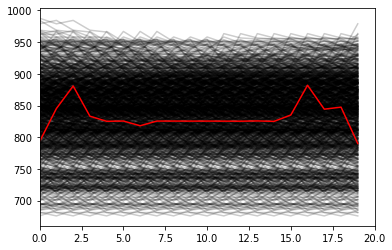

In [22]:
for xx in x_train[y_pred == 0]:    
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[0].ravel(), "r-")
plt.xlim(0, sz)

In [17]:
cluster0 = dba_km.cluster_centers_[0]

r1 = np.mean(cluster0)
print("\nMean: ", r1)
  
r2 = np.std(cluster0)
print("\nstd: ", r2)
  
r3 = np.var(cluster0)
print("\nvariance: ", r3)


Mean:  831.3288797549276

std:  21.554525726612024

variance:  464.5975792991796


(0.0, 20.0)

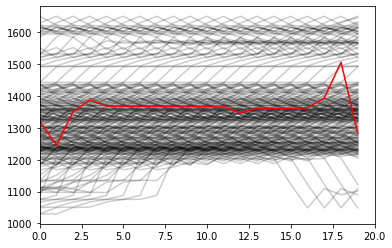

In [24]:
for xx in x_train[y_pred == 1]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[1].ravel(), "r-")
plt.xlim(0, sz)

In [19]:
cluster1 = dba_km.cluster_centers_[1]

r1 = np.mean(cluster1)
print("\nMean: ", r1)
  
r2 = np.std(cluster1)
print("\nstd: ", r2)
  
r3 = np.var(cluster1)
print("\nvariance: ", r3)


Mean:  1360.9172033105863

std:  47.14675121214435

variance:  2222.816149859835


(0.0, 20.0)

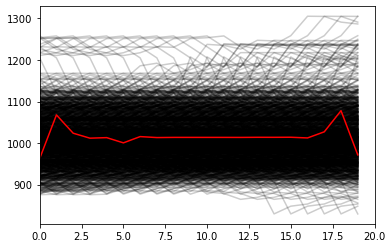

In [25]:
for xx in x_train[y_pred == 2]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[2].ravel(), "r-")
plt.xlim(0, sz)

In [21]:
cluster2 = dba_km.cluster_centers_[2]

r1 = np.mean(cluster2)
print("\nMean: ", r1)
  
r2 = np.std(cluster2)
print("\nstd: ", r2)
  
r3 = np.var(cluster2)
print("\nvariance: ", r3)


Mean:  1015.458067813681

std:  24.29754190095334

variance:  590.3705424285833


(0.0, 20.0)

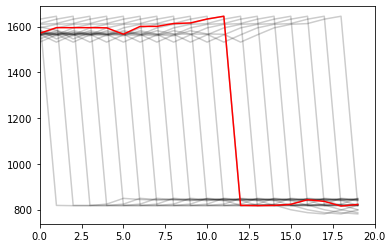

In [26]:
for xx in x_train[y_pred == 3]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[3].ravel(), "r-")
plt.xlim(0, sz)

In [23]:
cluster3 = dba_km.cluster_centers_[3]

r1 = np.mean(cluster3)
print("\nMean: ", r1)
  
r2 = np.std(cluster3)
print("\nstd: ", r2)
  
r3 = np.var(cluster3)
print("\nvariance: ", r3)


Mean:  1291.0608594489743

std:  381.7420402446067

variance:  145726.9852901149


In [22]:
# for xx in x_train[y_pred == 4]:
#     plt.plot(xx.ravel(), "k-", alpha=.2)
# plt.plot(dba_km.cluster_centers_[4].ravel(), "r-")
# plt.xlim(0, sz)

In [27]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [28]:
train_norm, test_norm = normalize_data(train_set, test_set)
train_norm, test_norm = normalize_data(train_set, test_set)

x_train, y_train = prepareDataForTraining(train_norm)
x_test, y_test = prepareDataForTraining(test_norm)

x_train = np.asarray(x_train).reshape(-1, window_size, 1)
y_train = np.asarray(y_train).reshape(-1, 1)
x_test = np.asarray(x_test).reshape(-1, window_size, 1)
y_test = np.asarray(y_test).reshape(-1, 1)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [29]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    


In [30]:
# make predictions
y_test_pred = model(x_test[:20])

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# y_test_pred = y_test_pred.detach().numpy()
# y_test = y_test_lstm.detach().numpy()

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:20,0], y_test_pred[:,0])
accuracy_reg = r2_score(y_test[:20], y_test_pred)
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')

Test Score: 0.01 MAPE
R-squared value is 0.378647250100435


In [44]:
# make predictions
y_test_pred = model(x_test[230:250])

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# y_test_pred = y_test_pred.detach().numpy()
# y_test = y_test_lstm.detach().numpy()

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[230:250,0], y_test_pred[:,0])
accuracy_reg = r2_score(y_test[230:250], y_test_pred)
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')

Test Score: 0.03 MAPE
R-squared value is 0.22332036897809615


In [59]:
# make predictions
y_test_pred = model(x_test[250:270])

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# y_test_pred = y_test_pred.detach().numpy()
# y_test = y_test_lstm.detach().numpy()

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[250:270], y_test_pred[:,0])
accuracy_reg = r2_score(y_test[250:270], y_test_pred)
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')

Test Score: 0.02 MAPE
R-squared value is 0.5254341429302563


In [60]:
# make predictions
y_test_pred = model(x_test[300:320])

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# y_test_pred = y_test_pred.detach().numpy()
# y_test = y_test_lstm.detach().numpy()

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[300:320], y_test_pred[:,0])
accuracy_reg = r2_score(y_test[300:320], y_test_pred)
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')

Test Score: 0.06 MAPE
R-squared value is -7.189163957760485


In [45]:
y_test_pred.shape

(20, 1)

In [61]:
preds = y_test_pred

r1 = np.mean(preds)
print("\nMean: ", r1)
  
r2 = np.std(preds)
print("\nstd: ", r2)
  
r3 = np.var(preds)
print("\nvariance: ", r3)


Mean:  1981.4104

std:  6.240365

variance:  38.942154


In [62]:
dtw_dist = []
clusters = []

for i in range(num_clusters):

  cluster = dba_km.cluster_centers_[i]

  X1, X2 = cluster, y_test_pred

  ## convert to np.array
  X1, X2 = np.asarray(X1), np.asarray(X2)

  dtw = TSdist.DTWDistance(X1, X2)
  dtw_dist.append(dtw)
  clusters.append(f'{i}')

finalResult = { "clusters" : clusters,    
    "DTW distance" : dtw_dist

    }

df1 = pd.DataFrame(finalResult)

In [63]:
pdc_dist = []
clusters = []

for i in range(num_clusters):

    cluster = dba_km.cluster_centers_[i]

    X1, X2 = cluster, y_test_pred

     ## convert to np.array
    X1, X2 = np.asarray(X1), np.asarray(X2)

    pdc = TSdist.PDCDistance(X1, X2)
    pdc_dist.append(pdc)
    clusters.append(f'{i}')

finalResult = { "clusters" : clusters,    
    "PDC distance" : pdc_dist

    }

df2 = pd.DataFrame(finalResult)

In [64]:
cort_dist = []
clusters = []

for i in range(num_clusters):

  cluster = dba_km.cluster_centers_[i]

  X1, X2 = cluster, y_test_pred

  # print(X2.shape)

  ## convert to np.array
  X1 = rpy2.robjects.IntVector(X1)
  X2 = rpy2.robjects.IntVector(X2)

  # print(type(X1))

  cort = TSdist.CortDistance(X1, X2, deltamethod="DTW")
  cort_dist.append(cort)
  clusters.append(f'{i}')

finalResult = { "clusters" : clusters,    
    "Temporal Correlation distance" : cort_dist

    }

df3 = pd.DataFrame(finalResult)

In [65]:
import scipy.stats

In [66]:
def jsd(p, q, base=np.e):
    '''
        Implementation of pairwise `jsd` based on  
        https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    '''
    if len(p)>len(q):
        p = np.random.choice(p,len(q)) # random.choice make same length to p/q
    elif len(q)>len(p):
        q = np.random.choice(q,len(p))
    ## convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    ## normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    
    return scipy.stats.entropy(p,m, base=base)/2. +  scipy.stats.entropy(q, m, base=base)/2

In [67]:
JSD = []
clusters = []

for i in range(num_clusters):
    
    cluster = dba_km.cluster_centers_[i]

    X1, X2 = cluster, y_test_pred

    jsd_res = jsd(X1, X2)

    JSD.append(jsd_res)
    clusters.append(f'{i}')



finalResult = { "clusters" : clusters,             
        "JS divergence" : JSD

}

df6 = pd.DataFrame(finalResult)

In [43]:
#Test data 0-20 points
result = pd.concat([df1, df2['PDC distance'], df3['Temporal Correlation distance'], df6['JS divergence']], axis=1)
result

,clusters,DTW distance,PDC distance,Temporal Correlation distance,JS divergence
0,0,[17098.65753656688],[0.42686590133060154],[21383.95579195726],[0.00015817681360714595]
1,1,[922.0878178537084],[0.033371349320385324],[1033.8921849716166],[0.00021968975985449103]
2,2,[9791.12751647636],[0.4843099592557527],[12872.55673725841],[0.0001366237464467443]
3,3,[12029.905601442573],[0.17138633618932841],[11672.81219460592],[0.010857918616502026]


In [53]:
# Test data from 230-250
result = pd.concat([df1, df2['PDC distance'], df3['Temporal Correlation distance'], df6['JS divergence']], axis=1)
result

,clusters,DTW distance,PDC distance,Temporal Correlation distance,JS divergence
0,0,[22886.84439622991],[1.3540354873985763],[23557.197305645055],[0.00019483746196208686]
1,1,[2282.6091791844233],[0.4919484387125004],[1970.981002531079],[0.00026698530769198926]
2,2,[15274.94423434826],[1.3298706826327642],[15992.06687244515],[0.00019934113151182358]
3,3,[8469.710781306443],[0.3917619378562862],[9241.122447096914],[0.012230068216806096]


In [68]:
#Test data 300-320 points
result = pd.concat([df1, df2['PDC distance'], df3['Temporal Correlation distance'], df6['JS divergence']], axis=1)
result

,clusters,DTW distance,PDC distance,Temporal Correlation distance,JS divergence
0,0,[43798.34040643253],[0.4179221422594157],[61779.06624264519],[9.062276104012605e-05]
1,1,[21686.70597567401],[0.1204430515031012],[32397.438370772474],[0.000166782673846001]
2,2,[36408.89084286617],[0.4256567953576651],[49944.75998566806],[7.874661902983334e-05]
3,3,[20380.381932114266],[0.2824799855782638],[15563.601274707145],[0.011884780103119006]


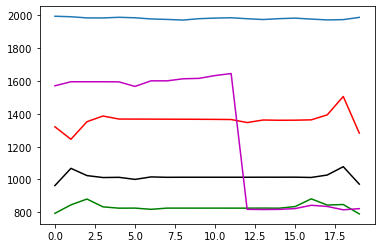

In [69]:
plt.plot(y_test_pred)
plt.plot(dba_km.cluster_centers_[0], 'g')
plt.plot(dba_km.cluster_centers_[1], 'r')
plt.plot(dba_km.cluster_centers_[2], 'k')
plt.plot(dba_km.cluster_centers_[3], 'm')

After clustering, computing distance between each cluster and data points between test set forecasts from 0-20, 230-270 and 300-320, we see how distance and visualization is differen. From all preious obserations data between 300-400 is something model has not seen before, there is a dataset shift. This is also clear from EWMA charts, comparing clustering results also shows the same.